In [1]:
import as_seg.scripts.default_path as paths
import as_seg.scripts.overall_scripts as scr
import as_seg.data_manipulation as dm
import as_seg.CBM_algorithm as CBM
import as_seg.autosimilarity_computation as as_comp
import as_seg.barwise_input as bi
from as_seg.model.current_plot import *

import math
import numpy as np
import pandas as pd
import mirdata
import os
import tensorly as tl

In [2]:
colors = ['tab:green', 'tab:purple','tab:red','tab:olive']
markers = ['^', 's', 'o','v']

bands_number = 7
autosimilarity_types = ["Cosine", "RBF"]#"Covariance", "RBF"]
pen_function = "modulo8"#["Nope", "modulo_oracle_salami"]
#penalty_functions_target =  ["Nope", "target_deviation_8_alpha_half", "target_deviation_8_alpha_one", "target_deviation_8_alpha_two"]#["Nope", "modulo_oracle_salami"]
features = ["log_mel_grill"]#["mel_grill","log_mel_grill", "nn_log_mel_grill", "pcp", "mfcc-nmfcc32"]
features_labels = ["Log Mel"]#["Mel", "Log Mel", "NNLMS", "Chromagram", "MFCC"]

lambda_range = np.concatenate([np.arange(0.1, 1.1, 0.1)])#2.1, 0.1)])

In [3]:
def compute_this_penalty_lambda_fitting(penalty_func, lambda_range, autosimilarity_type = "cosine", feature = "log_mel_grill", bands_number = bands_number):
    idx_song_max = 101 # Should be 101 for all the dataset, other values should be for tests only
    songs_range = range(1,idx_song_max) 
    subdivision = 96
    hop_length = 32
    hop_length_seconds = hop_length/44100
    ref_len_avg = 0
    
    results_songs_lambdas = math.inf * np.ones((len(songs_range), len(lambda_range), 2, 3)) # Songs, autosimilarity types, tol, metrics
    repartition_songs_lambdas = np.ones((len(lambda_range))) # Songs, autosimilarity types, tol, metrics
    
    lengths_all_lambda = []
    for i in range(len(lambda_range)):
        lengths_all_lambda.append([])
        
    for idx_song, song_name in enumerate(songs_range):
        spectrogram, bars, references_segments = scr.load_spec_annot_song_RWC(song_name, feature, hop_length)
        barwise_TF_matrix = bi.barwise_TF_matrix(spectrogram, bars, hop_length_seconds, subdivision)
        ref_in_bars = np.array(dm.segments_from_time_to_bar(references_segments, bars))
        ref_len_avg += len(references_segments) 
        
        autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = autosimilarity_type, normalise = True)
        for idx_lambda, lambda_penalty in enumerate(lambda_range):
            
            segments = CBM.compute_cbm(autosimilarity_barTF_matrix, penalty_weight = lambda_penalty, penalty_func = penalty_func, bands_number = bands_number)[0]                
            #segments_in_time = dm.segments_from_bar_to_time(segments, bars)

            prec0bar, rap0bar, f_mes0bar = dm.compute_score_of_segmentation(ref_in_bars, segments, window_length = 0)
            prec1bar, rap1bar, f_mes1bar = dm.compute_score_of_segmentation(ref_in_bars, segments, window_length = 1)
            this_score = [[round(prec0bar,4),round(rap0bar,4),round(f_mes0bar,4)], [round(prec1bar,4),round(rap1bar,4),round(f_mes1bar,4)]]
            results_songs_lambdas[idx_song, idx_lambda] = this_score
            
    print(f"Avg nmber of annotations per song : {ref_len_avg/(idx_song_max - 1)}")
            
    odd_songs = range(0,idx_song_max - 1,2) # Weird, but shouldn't confuse indexes and number
    even_songs = range(1,idx_song_max - 1,2)
                
    #for idx_lambda, lambda_penalty in enumerate(lambda_range):
        #print(lambda_penalty)
        #plot_lenghts_hist(lengths_all_lambda[idx_lambda])
    
    avg_odd_songs = [np.mean(results_songs_lambdas[odd_songs, i, 0, 2]) + np.mean(results_songs_lambdas[odd_songs, i, 1, 2]) for i in range(len(lambda_range))]
    best_lambda_idx_odd = np.argmax(avg_odd_songs)
    print(f"Best lambda odd songs: {lambda_range[best_lambda_idx_odd]}")
    res_odd = math.inf * np.ones((2,3))
    for tol in range(2):
        for metric in range(3):
            res_odd[tol, metric] = np.mean(results_songs_lambdas[even_songs, best_lambda_idx_odd, tol, metric])
    
    avg_even_songs = [np.mean(results_songs_lambdas[even_songs, i, 0, 2]) + np.mean(results_songs_lambdas[even_songs, i, 1, 2]) for i in range(len(lambda_range))]
    best_lambda_idx_even = np.argmax(avg_even_songs)
    print(f"Best lambda even songs: {lambda_range[best_lambda_idx_even]}")
    res_even = math.inf * np.ones((2,3))
    for tol in range(2):
        for metric in range(3):
            res_even[tol, metric] = np.mean(results_songs_lambdas[odd_songs, best_lambda_idx_even, tol, metric])
    
    return np.mean(np.array([res_odd, res_even]), axis=0)#np.add(np.array(res_odd), np.array(res_even))

def compute_avg_diff_as_this_penalty(autosimilarity_types, penalty_func, lambda_range, feature = "log_mel_grill", bands_number = bands_number):
    results_avg_as = math.inf * np.ones((len(autosimilarity_types), 2, 3)) # autosimilarity types, tol, metrics
    all_avg_res_line = []
    indexes = []
    for idx_as, autosimil in enumerate(autosimilarity_types):
        print(f"Autosimilarity: {autosimil}")
        scores = compute_this_penalty_lambda_fitting(penalty_func, lambda_range, autosimilarity_type = autosimil, feature = feature, bands_number = bands_number)
        results_avg_as[idx_as] = scores
        all_avg_res_line.append(scores.flatten(order = 'C'))
        indexes.append(f"Autosimilarity: {autosimil}")
    np_all_avg_res_line = np.array(all_avg_res_line)
    dataframe = pd.DataFrame(np_all_avg_res_line, columns = ['P0b', 'R0b', 'F0b','P1b', 'R1b', 'F1b'], index = indexes)
    display(dataframe.style.bar(subset=["F0b","F1b"], color='#5fba7d'))

    return results_avg_as

In [4]:
def compute_lengths_lambda_crossval(penalty_func, lambda_odd, lambda_even, autosimilarity_type = "cosine", feature = "log_mel_grill", bands_number = bands_number):
    subdivision = 96
    hop_length = 32
    hop_length_seconds = hop_length/44100

    lengths = []
    odd_songs = range(1,101,2)
    even_songs = range(2,101,2)
        
    for idx_song, song_name in enumerate(odd_songs):
        spectrogram, bars, references_segments = scr.load_spec_annot_song_RWC(song_name, feature, hop_length)
        barwise_TF_matrix = bi.barwise_TF_matrix(spectrogram, bars, hop_length_seconds, subdivision)
        autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = autosimilarity_type, normalise = True)
            
        segments = CBM.compute_cbm(autosimilarity_barTF_matrix, penalty_weight = lambda_even, penalty_func = penalty_func, bands_number = bands_number)[0]                
        segments_in_time = dm.segments_from_bar_to_time(segments, bars)
        for end, start in segments:
            lengths.append(start - end)
            
    for idx_song, song_name in enumerate(even_songs):
        spectrogram, bars, references_segments = scr.load_spec_annot_song_RWC(song_name, feature, hop_length)
        barwise_TF_matrix = bi.barwise_TF_matrix(spectrogram, bars, hop_length_seconds, subdivision)
        autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = autosimilarity_type, normalise = True)
            
        segments = CBM.compute_cbm(autosimilarity_barTF_matrix, penalty_weight = lambda_odd, penalty_func = penalty_func, bands_number = bands_number)[0]                
        segments_in_time = dm.segments_from_bar_to_time(segments, bars)
        for end, start in segments:
            lengths.append(start - end)
            
    print(f"penalty_func: {penalty_func}, autosimilarity_type: {autosimilarity_type}, bands_number: {bands_number}")
    plot_lenghts_hist(lengths)


In [18]:
def plot_kernels_as(results_diff_as, kernels_or_features, autosimilarities, tol, title = None):
    # Order results_diff_as: kernels ou features, as, tol
    subaxis = autosimilarities
    plt.rcParams.update({'font.size': 18})
    
    width=0.25
    gap = (len(autosimilarities) + 1)*width
    colors = ["#62d5b4", "#317373", "#184a4a"]#['skyblue', 'steelblue', 'darkorange', 'brown']
    
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    ax.set_ylim( 25, 110 )
    tab = []
    current_start = 0
    for i in range(len(autosimilarities)):
        indexes = [current_start + j*gap for j in range(len(kernels_or_features))]
        tab.append(ax.bar(indexes, results_diff_as[:,i,tol], color=colors[i], width=width, align='edge'))
        for idx_x, x in enumerate(indexes):
            height = results_diff_as[idx_x, i, tol] 
            plt.text(x +width/2,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        current_start += width

    ax.set_xticks([current_start/2 + j*gap for j in range(len(kernels_or_features))])
    ax.set_xticklabels(kernels_or_features)
    if tol == 1:
        ax.legend(labels=subaxis, loc='lower left')
    else:
        ax.legend(labels=subaxis, loc='lower left', ncol = 3)

    ax.set_ylabel("F measure")
    #fig.savefig("C:/Users/amarmore/Desktop/Mes papiers/figures/results_barcomp_05.pdf", bbox_inches = "tight")#, format='png')
    if title != None:
        plt.title(title)
    plt.show()

Kernel: 7
Feature: log_mel_grill
Autosimilarity type: Cosine
Avg nmber of annotations per song : 17.8
Best lambda odd songs: 0.1
Best lambda even songs: 0.1
Autosimilarity type: RBF
Avg nmber of annotations per song : 17.8
Best lambda odd songs: 0.1
Best lambda even songs: 0.2


,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.609506,0.589918,0.595079,0.762468,0.733246,0.741528
Autosimilarity: RBF,0.650922,0.713365,0.674391,0.784312,0.860089,0.812759


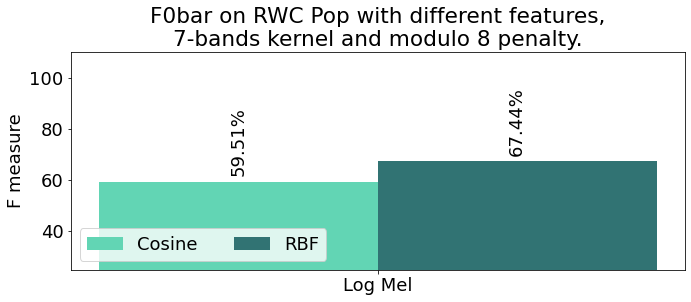

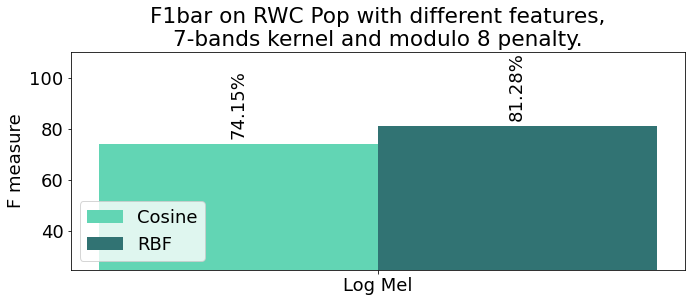

---------------
------------
------------
------------
------------


In [6]:
print(f"Kernel: {bands_number}")

res_avg_target = math.inf * np.ones((len(features), len(autosimilarity_types), 2, 3))

for idx_feat, feature in enumerate(features):
    print(f"Feature: {feature}")
    indexes = []
    results_this_function = math.inf * np.ones((len(autosimilarity_types), 2, 3))
    for idx_as, autosimil_type in enumerate(autosimilarity_types):
        print(f"Autosimilarity type: {autosimil_type}")
        res = compute_this_penalty_lambda_fitting(pen_function, lambda_range, autosimilarity_type = autosimil_type, feature = feature, bands_number = bands_number)
        results_this_function[idx_as] = res
        indexes.append(f"Autosimilarity: {autosimil_type}")
    res_avg_target[idx_feat] = results_this_function
    dataframe = pd.DataFrame(results_this_function.reshape(results_this_function.shape[0], 6), columns = ['P0.5', 'R0.5', 'F0.5','P3', 'R3', 'F3'], index = indexes)
    display(dataframe.style.bar(subset=["F0.5","F3"], color='#5fba7d'))
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 0, title = f"F0bar on RWC Pop with different features,\n7-bands kernel and modulo 8 penalty.")
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 1, title = f"F1bar on RWC Pop with different features,\n7-bands kernel and modulo 8 penalty.")
print("---------------\n------------\n------------\n------------\n------------")

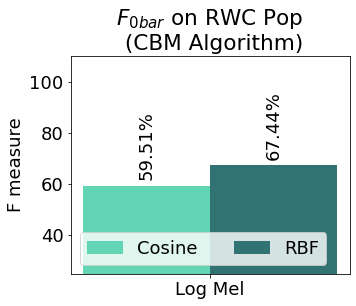

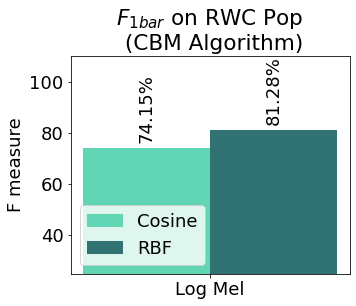

In [20]:
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 0, title = "$F_{0 bar}$ on RWC Pop\n (CBM Algorithm)")
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 1, title = "$F_{1 bar}$ on RWC Pop\n (CBM Algorithm)")

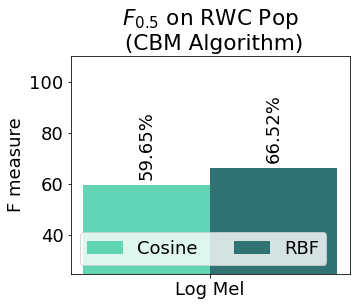

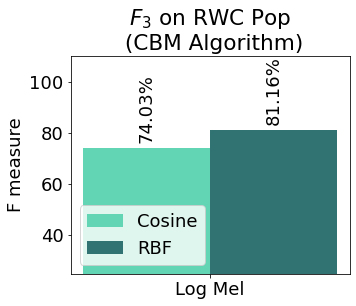

In [22]:
plot_kernels_as(np.array([[[59.65, 74.03],[66.52, 81.16]]]), features_labels, autosimilarity_types, 0, title = "$F_{0.5}$ on RWC Pop\n (CBM Algorithm)")
plot_kernels_as(np.array([[[59.65, 74.03],[66.52, 81.16]]]), features_labels, autosimilarity_types, 1, title = "$F_{3}$ on RWC Pop\n (CBM Algorithm)")

In [8]:
np.round(100 * res_avg_target[:,:,:,2], decimals = 2)

array([[[59.51, 74.15],
        [67.44, 81.28]]])